In [515]:
import numpy as np
from tqdm import tqdm
import random
import gymnasium as gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque

In [516]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode='ansi')
state, _ = env.reset()

# The state of the environment
print(state)

print("decoded state")
print(list(env.decode(state)))


#The number of states in the environment
print(env.observation_space.n)

#The number of actions in the environment
print(env.action_space.n)

#Take a step in the environment
next_state, reward, done, _, _ = env.step(1)
print("decoded state")
print(list(env.decode(next_state)))

#Render the environment
env.render()

174
decoded state
[1, 3, 3, 2]
500
6
decoded state
[0, 3, 3, 2]


/home/adi/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


'+---------+\n|R: | :\x1b \x1b:G|\n| : | : : |\n| : : : : |\n| | : | : |\n|\x1bY\x1b| : |\x1bB\x1b: |\n+---------+\n  (North)\n'

In [517]:
total_options = 10
# actions:  ['down', 'up', 'right', 'left', 'pickup', 'dropoff']
actions = [0, 1, 2, 3, 4, 5]
# options: ['toR', 'toG', 'toY', 'toB']
options = [6, 7, 8, 9]

goal_states = [[0, 0], [0, 4], [4, 0], [4, 3]]

Q_values = np.random.random((env.observation_space.n, total_options))
Q_options = np.random.random((len(options), 25, 4))

# Softmax function
def softmax(Q, state, tau):
    q_values = Q[state]
    q_values = q_values / tau
    max_q = np.max(q_values)
    e = np.exp(q_values - max_q)
    dist = e / np.sum(e)
    action = np.random.choice(len(dist), p=dist)
    return action

def epsilon_greedy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, 4)
    else:
        action = np.argmax(Q[state])
    return action

In [518]:
def decode_state(env, state):
    return list(env.decode(state))

In [519]:
### HYPERPARAMETERS ###
ALPHA = 0.1
GAMMA = 0.9
TAU = 0.7
DECAY_CONSTANT = 0.995

In [520]:
def execute_option(env, Q_values, Q_options, Q_freq, option_freq, option, state, update_Q=True, policy = softmax):
    optdone = False
    optact = 0
    if option < 6:
        next_state, reward, done, _, _ = env.step(option)
        optdone = done
        optact = option
        if update_Q:
            Q_values[state][option] = Q_values[state][option] + ALPHA * (reward + GAMMA * np.max(Q_values[next_state]) - Q_values[state][option])
            Q_freq[state][option] += 1
        return next_state, reward, done, [Q_values, Q_options, Q_freq, option_freq]
        
    if option >= 6:
        reward_bar = 0
        chosen_option = options.index(option)
        chosen_Q = Q_options[chosen_option]
        counter = 0
        current_state = state
        while optdone == False:
            state_value = 5 * decode_state(env, state)[0] + decode_state(env, state)[1]
            optact = policy(chosen_Q, state_value, TAU)
            next_state, reward, done, _, _ = env.step(optact)
            next_state_value = 5 * decode_state(env, next_state)[0] + decode_state(env, next_state)[1]
            reward_bar += reward * (GAMMA ** counter)
            GOAL_REWARD = 20
            if decode_state(env, next_state)[:2] == goal_states[chosen_option]:
                optdone = True
                if update_Q:
                    Q_values[current_state, option] += ALPHA * (reward_bar - Q_values[current_state, option] + GAMMA**counter * np.max(Q_values[next_state]))
                    Q_freq[current_state, option] += 1
                reward += GOAL_REWARD 
            if update_Q:
                chosen_Q[state_value][optact] = chosen_Q[state_value][optact] + ALPHA * (reward + GAMMA * np.max(chosen_Q[next_state_value]) - chosen_Q[state_value][optact])
                option_freq[chosen_option][state_value][optact] += 1
            counter += 1

            state = next_state
        Q_options[chosen_option] = chosen_Q                
        return next_state, reward_bar, done, [Q_values, Q_options, Q_freq, option_freq]

In [521]:
#### SMDP Q-Learning
episodes = 10000
total_rewards = np.zeros((episodes))

main_update_freq = np.zeros(Q_values.shape)
option_update_freq = np.zeros(Q_options.shape)


def SMDP_Q_Learning(env, Q_values, Q_options, main_update_freq, option_update_freq, episodes, policy=softmax, update_Q = True,TAU = TAU):
    # Iterate over 1000 episodes
    for i in tqdm(range(episodes)):
        state, _ = env.reset()    
        done = False
        # While episode is not over
        while not done:
            # Choose action        
            action = policy(Q_values, state, TAU)
            # Execute action
            next_state, reward, done, value_array = execute_option(env, Q_values, Q_options, main_update_freq, option_update_freq, action, state, update_Q=update_Q, policy=policy)
            Q_values, Q_options, main_update_freq, option_update_freq = value_array
            state = next_state
            total_rewards[i] += reward
        TAU = max(0.01, TAU * DECAY_CONSTANT)
    return Q_values, Q_options, main_update_freq, option_update_freq


In [522]:
Q_values, Q_options, main_update_freq, option_update_freq = SMDP_Q_Learning(env, Q_values, Q_options, main_update_freq, option_update_freq, episodes, policy=softmax, update_Q = True, TAU = TAU)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:29<00:00, 335.61it/s]


In [523]:
def plot_rewards(rewards):
    avg_rew = []
    plt.figure("Reward Plot")
    scores_window = deque(maxlen=300)
    for reward in rewards:
        scores_window.append(reward)
        avg_rew.append(np.mean(scores_window))
    plt.plot(avg_rew)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.ylim(-500, 200)  # Set the Y-axis range


9.415243199


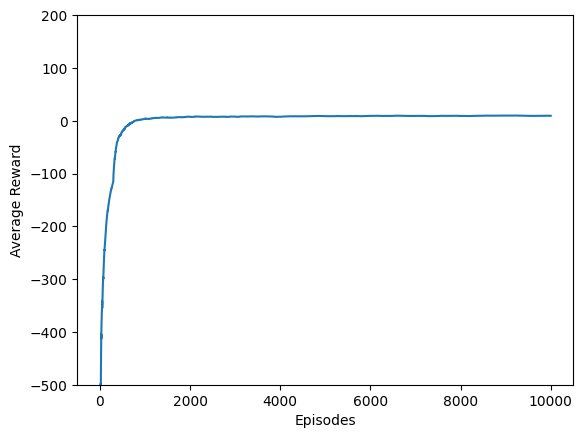

In [524]:
plot_rewards(total_rewards)
print(np.mean(total_rewards[-100:]))

In [525]:
def options_plot(Q_options):
    GOAL_STATES = [[0, 0], [0, 4], [4, 0], [4, 3]]
    actions = ['down', 'up', 'right', 'left']
    option_name = ['toR', 'toG', 'toY', 'toB']
    integer = 0
    for i in Q_options:
        Q_map = np.zeros((5,5))
        for j in range(25):
            Q_map[j//5, j%5] = np.argmax(i[j])

        fig, ax = plt.subplots()
        ax.imshow(Q_map, cmap='YlOrBr')

        # Plot goal states in green
        ax.add_patch(plt.Rectangle((GOAL_STATES[integer][1]-0.5, GOAL_STATES[integer][0]-0.5), 1, 1, color='green'))

        integer += 1
        for x in range(5):
            for y in range(5):
                action = Q_map[x, y]
                dx = 0
                dy = 0
                if action == 0:  # down
                    dy = 0.4
                elif action == 1:  # up
                    dy = -0.4
                elif action == 2:  # right
                    dx = 0.4
                elif action == 3:  # left
                    dx = -0.4

                ax.annotate("", xy=(y+dx, x+dy), xytext=(y, x),
                            arrowprops=dict(arrowstyle="->", color='black', linewidth=2))
        plt.axvline(x=0.5, ymin=-1, ymax=0.4, color='blue', linewidth=10)
        plt.axvline(x=1.5, ymin=1, ymax=0.6, color='blue', linewidth=10)
        plt.axvline(x=2.5, ymin=-1, ymax=0.4, color='blue', linewidth=10)



        plt.axis('off')
        plt.title('Option: ' + option_name[(integer-1)])

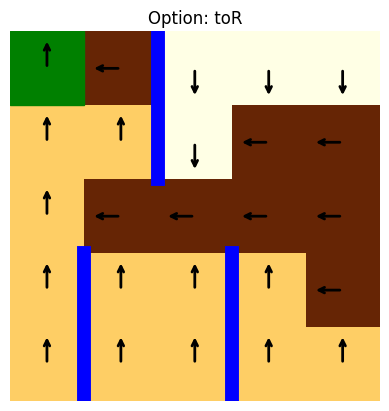

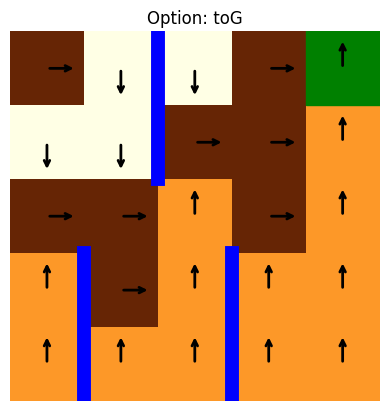

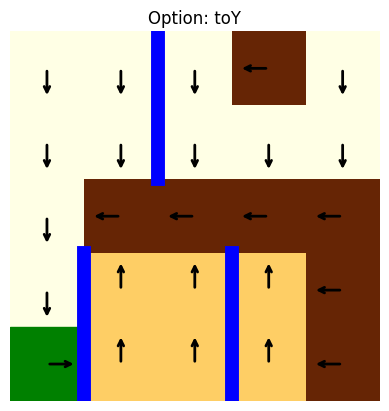

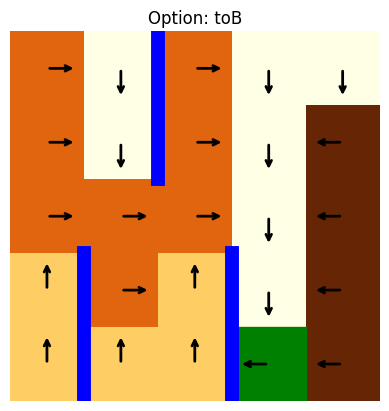

In [526]:
options_plot(Q_options)


In [527]:
import seaborn as sns
def plot_Q(q_values, message="Q plot"):
    options_name = ['toR', 'toG', 'toY', 'toB']
    options = ['down', 'up', 'right', 'left']
    integer = 0
    for q_map in q_values:
        Q = np.zeros((5, 5, 4))
        for i in range(5):
            for j in range(5):
                state_num = 5 * i + j
                Q[i, j] = q_map[state_num]

        plt.figure(figsize=(6, 6))
        plt.title(message + ": " + options_name[integer])
        sns.heatmap(Q.sum(axis=2), cmap='YlOrBr', annot=True, fmt=".2f", cbar=True, square=True, linewidths=2)
        plt.xlabel("Column")
        plt.ylabel("Row")
        plt.axis('off')
        plt.show()
        integer += 1

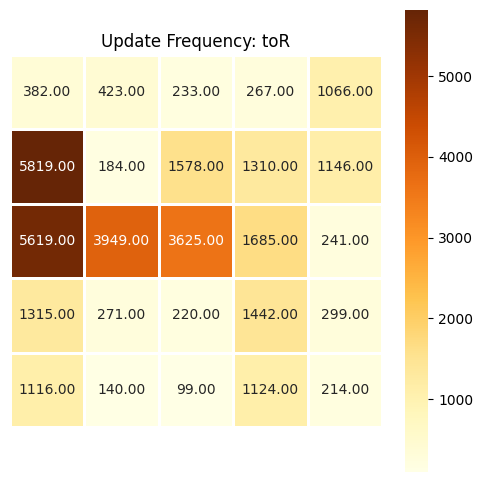

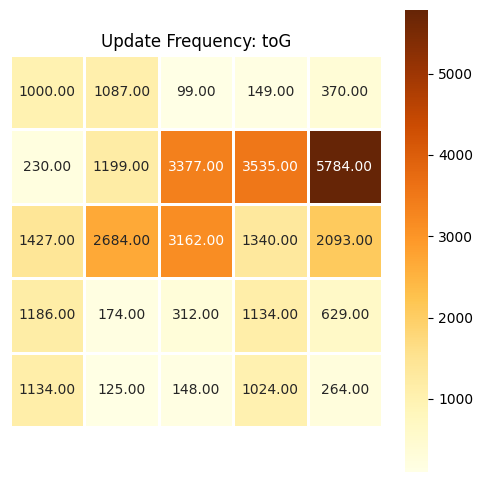

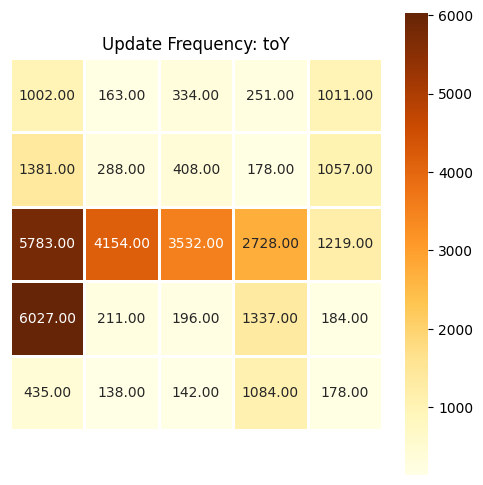

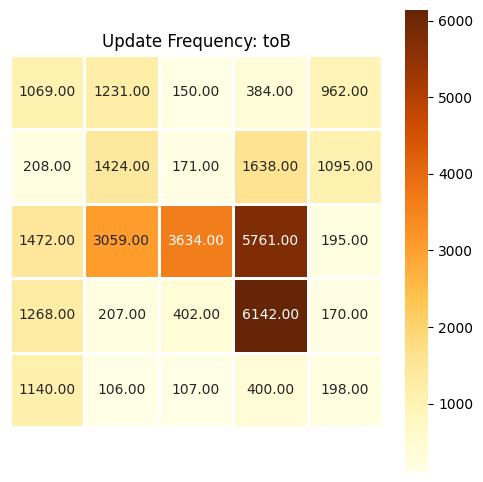

In [528]:
plot_Q(option_update_freq, "Update Frequency")

Passenger locations:</br>
    0: Red</br>
    1: Green</br>
    2: Yellow</br>
    3: Blue</br>
    4: In taxi</br>

Destinations:</br>
    0: Red</br>
    1: Green</br>
    2: Yellow</br>
    3: Blue</br>

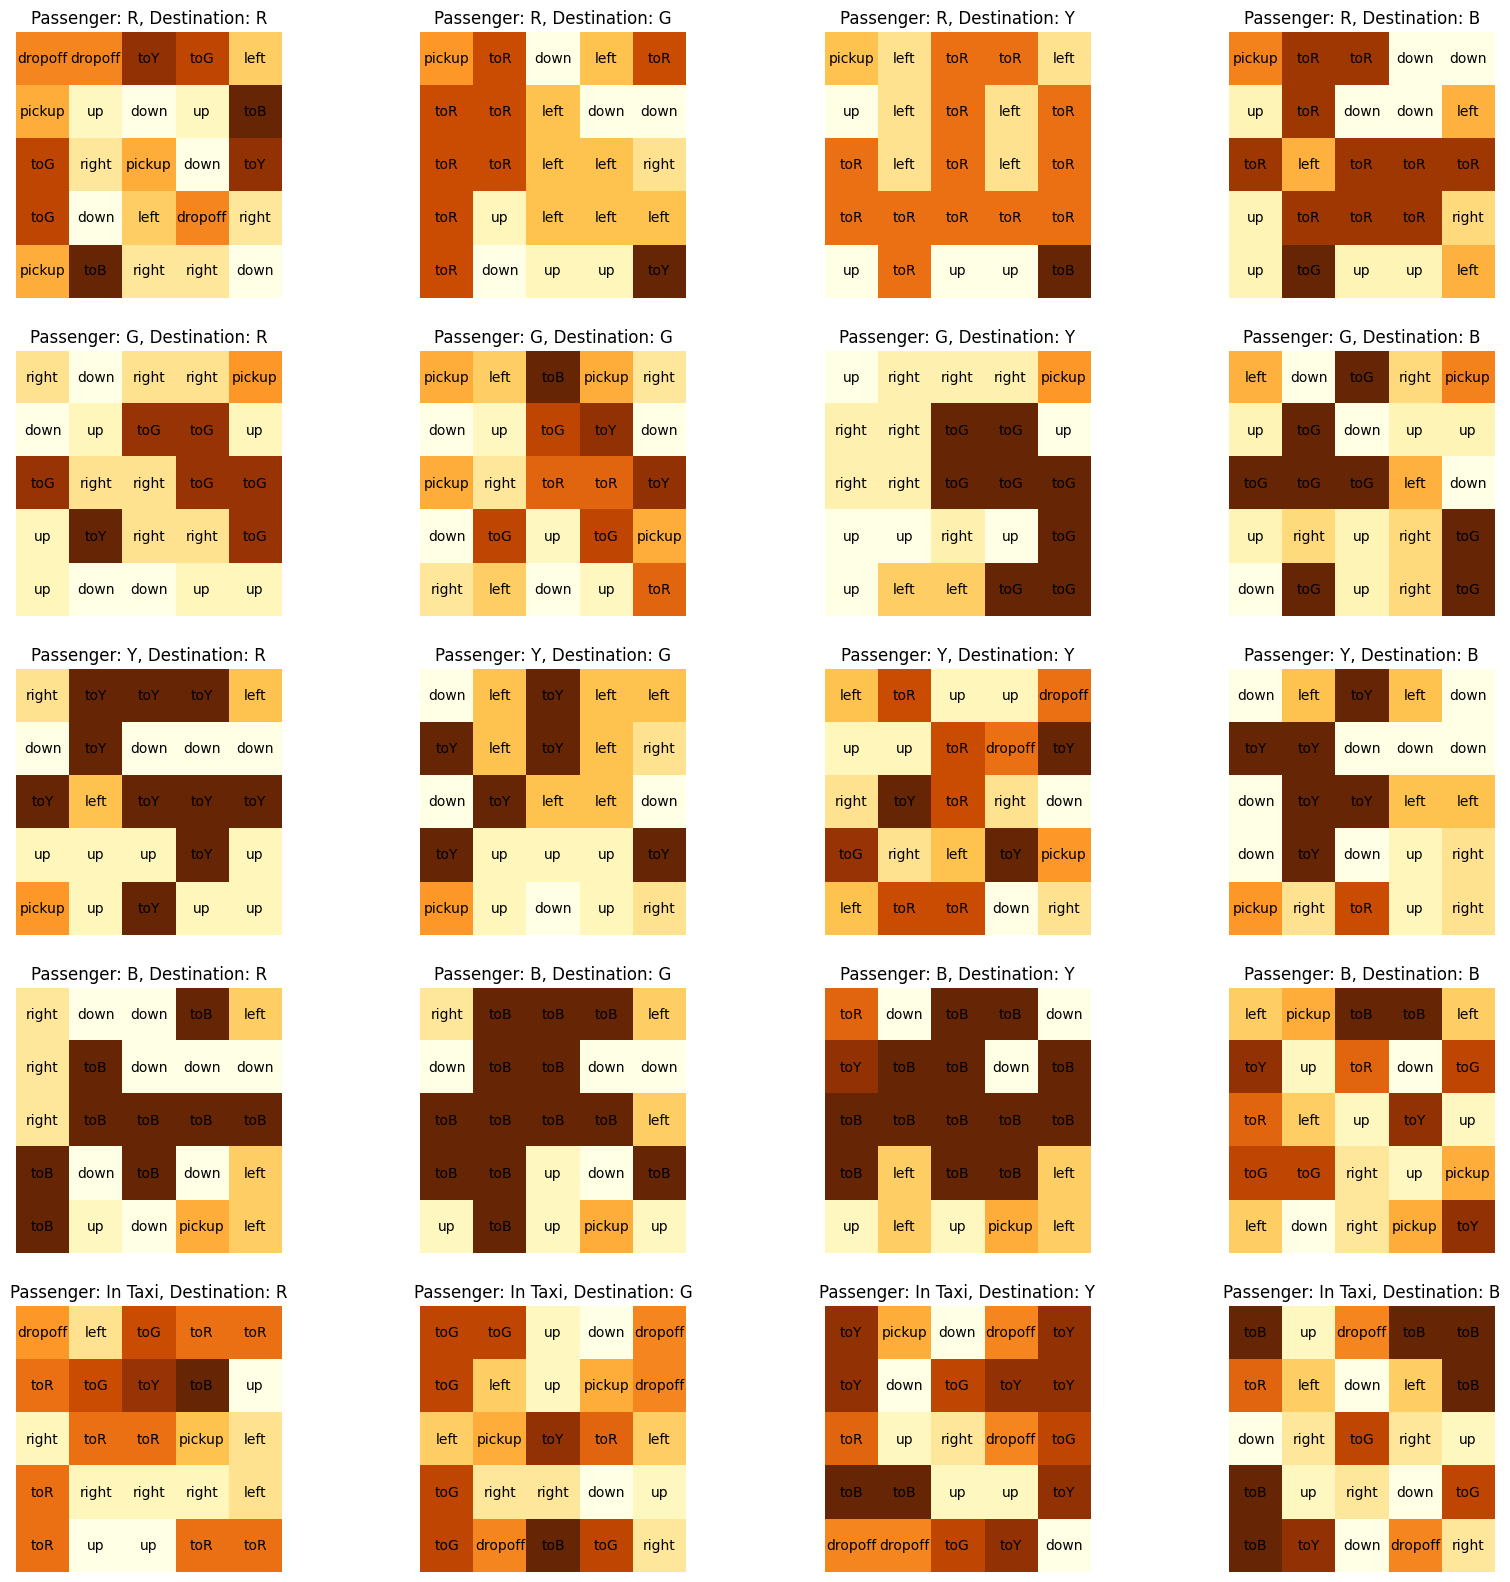

In [529]:
PASSENGER_LOCATIONS = [0, 1, 2, 3, 4]
PASSENGER_LOCATIONS_TEXT = ['R', 'G', 'Y', 'B', 'In Taxi']
DESTINATIONS = [0, 1, 2, 3]
DESTINATIONS_TEXT = ['R', 'G', 'Y', 'B']

ACTIONS_OPTIONS = ['down', 'up', 'right', 'left', 'pickup', 'dropoff', 'toR', 'toG', 'toY', 'toB']

fig, ax = plt.subplots(5, 4, figsize=(20, 20))

for PASS_LOC in PASSENGER_LOCATIONS:
    for DEST in DESTINATIONS:
        Q_MAP = np.zeros((5, 5, 10))
        for i in range(5):
            for j in range(5):
                state = ((5*i + j) * 5 + PASS_LOC) * 4 + DEST
                Q_MAP[i, j] = Q_values[state]
        
        ax[int(PASS_LOC), int(DEST)].imshow(np.argmax(Q_MAP, axis=2), cmap='YlOrBr')
        ax[int(PASS_LOC), int(DEST)].set_title(f"Passenger: {PASSENGER_LOCATIONS_TEXT[int(PASS_LOC)]}, Destination: {DESTINATIONS_TEXT[int(DEST)]}")
        ax[int(PASS_LOC), int(DEST)].axis('off')

        for i in range(5):
            for j in range(5):
                state = (5*i + j)*4 + int(PASS_LOC)*4 + int(DEST)
                anno = ACTIONS_OPTIONS[np.argmax(Q_MAP[i,j])]
                size='medium'
                ax[int(PASS_LOC), int(DEST)].text(j , i, anno, ha='center', va='center', color='black', size=size)

plt.show()
        